# Experiment with response of WAsP's Roughness Change modelling

In contrast to the graphic-user interface version of WAsP, `pywasp` facilitates convenient re-calculation while varying the inputs or parameters; this is useful towards sensitivity studies and uncertainty quantification. 

In this notebook, we will use `pywasp` to look at the "speedups" (fractional wind speed perturbations) predicted by WAsP's roughness change modelling, exploring the sensitivity of predicted speedups to various parameters describing a single roughness change line.

For simplicity, the single roughness change line will be represented as a circular roughness change. 
Then, since since all directional sectors will give the same result, we can just use results from one sector.

The circular roughness change is depicted in the image below, where the point of wind speed calculation (representing e.g. a measurement mast or turbine) is located at the 'X'. A roughness change contour is created with a radius `r`; for flow approaching the point X, the roughness changes from an `outer-roughness` (dark green area sourrounding the circle) to an `inner-roughness` (light green circle).

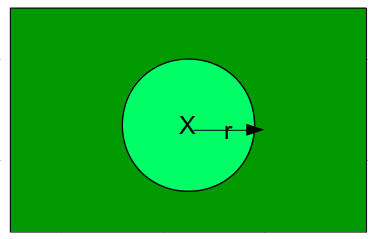

In this Jupyter notebook, we will:

1. Identify the inputs involved in calculating the effects of a roughness change.
2. Create a `pandas.DataFrame` of test cases based on varying the different inputs.
3. Call a function that calculates roughness-induced speedups for one sector, based on a `pandas.Series` of inputs.
4. Examine the speedup results to understand some of the behavior of the WAsP roughness change modelling.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pywasp as pw
import windkit as wk
#Ignore shapely warnings
import warnings
warnings.filterwarnings('ignore')

## Create single-contour map of roughness change

We provide you a python module/function called `circular_roughness_map`, which approximates a single circular roughness-change line by creating a 12-sided polygon; i.e., since 12 sectors are typically used with WAsP, we will essentially be considering a single line approximately perpendicular to the incoming flow in a sector.

The function requires the following inputs:

 - `radius` of the circle;
 - the inner-roughness length `z01`; and
 - the outer-roughness length `z02`.

These are passed/input into the module, via
```
circular_roughness_map(radius, z01, z02)
```

Let's `import` this function, and use it to generate an example of a simple roughness map.

> **__jupyter notebook reminder__**: In notebooks you can see information about a python function by by placing a `?` in front of it, and you can show the entire function's code by using`??`.  (For example,`??circular_roughness_map`.)

In [2]:
from circular_roughness_map import circular_roughness_map

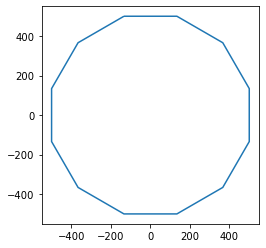

In [3]:
rgh_map = circular_roughness_map(500, .0002, 0.01)
rgh_map.plot();

The plot shows only a 'circle' represented by 12 points corresponding to the default number of roughness rose sectors (i.e., it consists of a line every 30°, perpendicular to the incoming flow in the center of each sector). 

To verify that the roughness lengths are correctly set, we can plot `'rgh_map'` as a raster map: 

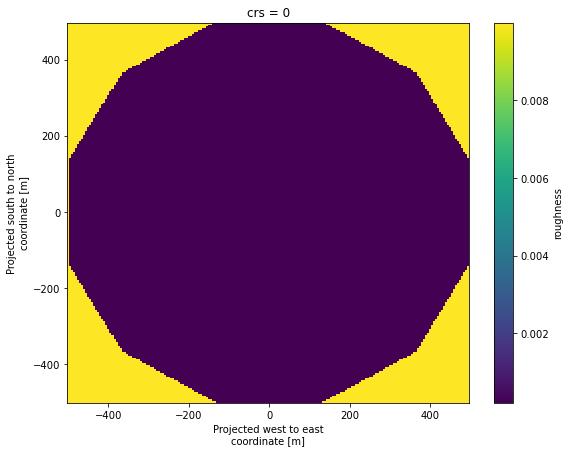

In [4]:
pw.vectormap_to_rastermap(rgh_map, res = 5).plot(figsize=(9, 7));

We can also see the value of the dataset by printing it:

In [5]:
print(rgh_map)

   z0_left  z0_right                                           geometry
0     0.01    0.0002  LINESTRING (-133.975 500.000, 133.975 500.000,...


## Setup the test cases

We will setup a number of roughness test-cases, which we will use later on to assess the response of WAsP's Roughness Change model. 
The test cases will be described by the map, height of interest, and two parameters in the $\Delta z_0$ model.  Specifically, these are: 
 - `radius` of the circle
 - `z01` the `inner-roughness` length
 - `z02` the `outer-roughness` length
 - `height` above the ground level where the roughness change induced speedups will be assessed
 - `p40` parameter for upper kink $(h_\textrm{upper}/h)$ in roughness-change profile/interpolation
 - `p41` parameter for lower kink $(h_\textrm{lower}/h)$ in roughness-change profile/interpolation
 
We will vary `radius`, `z01`, `z02` and `height` in our test cases, but use the default values of `p40` and `p41`.

> **__pywasp note:__** `p40` and `p41` are used to calculate the range of heights of the internal boundary layer, which corresponds to the transition layer between the wind profiles downstream and upstream of the roughness change (see the figure below). By default we say that the transition layer occupies the range of heights starting at 9% all the way to 30% of the internal boundary layer height. Considering the notation in the image below this means that $h_1=h_\textrm{upper}=0.3h$, while $h_2=h_\textrm{lower}=0.09h$; thus we'll pick `p40`=0.3 and `p41`=0.09. 

![IBL structure](images/IBL_layers.png)
*Image source: M.Sci. thesis of Tsz Yan Kwok, DTU Wind Energy M-0214 (2018); or Sempreviva, et al. in BLM (1990)*

Here we will create a Pandas DataFrame called `tests`, which can be thought of as similar to an Excel Spreadsheet; it will contain columns of the 6 quantities mentioned above. 

We will use the `numpy.meshgrid` function, to create an orthogonal dataset out of all of the lists we provide as input: 21 different distances to the roughness change (radii), 3 heights, 3 upwind and 3 downwind $z_0$; varying each of these individually, this gives us a total of 567 unique cases for our test.

> __**WAsP vs. `pywasp` note**__:  WAsP interprets map values of $z_0=0$m as being water, which it then uses to later invoke offshore stability and assign a roughness of 0.2mm; zero roughness does not exist.  
However, when directly using `pywasp`'s roughness-change modelling, one can specify the water roughness directly (0.0002m as done in below list of $z_0$ value).

In [6]:
rad = np.linspace(500., 50000., 21) # Radius of the circle
height = [10., 50., 100.] # Height above ground
z0upstr = [.0002, 0.03, 0.3]  # upstream (outer) roughness length
z0downstr = [0.01, 0.1, 0.5]    # downstream (inner) roughness length
p40 = [.30]               # Factor for upper kink in roughness change profile
p41 = [.09]               # Factor for lower kink in roughness change profile


tests = pd.DataFrame(np.array(np.meshgrid(rad, z0downstr, z0upstr, height, p40, p41, )).T.reshape(-1, 6), 
                         columns = ["radius", "z01", "z02", "height", "p40", "p41"])

tests[:10]# showing only first 10 rows out of 567

radius   z01     z02  height  p40   p41
0   500.0  0.01  0.0002    10.0  0.3  0.09
1   500.0  0.10  0.0002    10.0  0.3  0.09
2   500.0  0.50  0.0002    10.0  0.3  0.09
3  2975.0  0.01  0.0002    10.0  0.3  0.09
4  2975.0  0.10  0.0002    10.0  0.3  0.09
5  2975.0  0.50  0.0002    10.0  0.3  0.09
6  5450.0  0.01  0.0002    10.0  0.3  0.09
7  5450.0  0.10  0.0002    10.0  0.3  0.09
8  5450.0  0.50  0.0002    10.0  0.3  0.09
9  7925.0  0.01  0.0002    10.0  0.3  0.09

## Create a column of "speedups"

We will create a new column `'speedup'`, containing the dimensionless speed perturbations caused by the roughness change, and add it to the `DataFrame` called `tests`.
> **__WAsP note__**: WAsP's "speedups" are independent of the wind speed, and thus given as dimensionless values, i.e. $U_\textrm{perturbed}/U_\textrm{inflow}$.  These are typically expressed as a decimal or as a percentage (e.g. 0.92 or 92% due to some upwind roughness change).  

> **__`pywasp` note__**: `pywasp` outputs speedups (flow perturbations) as decimal values, not percentages. 

To calculate our "speedups" we use a function provided in the module `calc_rgh_speedup`. 
As input this function takes the 6 quantities mentioned so far; i.e., it takes a single row of our `tests` DataFrame.  
We can loop over all of the rows of `tests`, using the `iterrows` function for `DataFrame`s, calculating the speedup for each row and `insert`ing the results as a new column to `tests`.

> **__Jupyter/python note:__** Here we also use python's built-in `time` function to show how long it takes to run our tests. By preceding it with double percentage signs (`%%`), we signify that we want to capture the time evaluating the whole _cell;_ a single `%` will only apply to the line that `time` is connected to.

In [8]:
%%time
from calc_rgh_speedup import calc_rgh_speedup

speedup = [calc_rgh_speedup(row) for index, row in tests.iterrows()]
tests.insert(6, "speedup", speedup, True)

tests[:10] # showing only first 10 rows out of 567

CPU times: user 2min 32s, sys: 947 ms, total: 2min 33s
Wall time: 1min 28s


radius   z01     z02  height  p40   p41   speedup
0   500.0  0.01  0.0002    10.0  0.3  0.09  0.951510
1   500.0  0.10  0.0002    10.0  0.3  0.09  0.849217
2   500.0  0.50  0.0002    10.0  0.3  0.09  0.694407
3  2975.0  0.01  0.0002    10.0  0.3  0.09  0.903054
4  2975.0  0.10  0.0002    10.0  0.3  0.09  0.779925
5  2975.0  0.50  0.0002    10.0  0.3  0.09  0.629846
6  5450.0  0.01  0.0002    10.0  0.3  0.09  0.910635
7  5450.0  0.10  0.0002    10.0  0.3  0.09  0.791987
8  5450.0  0.50  0.0002    10.0  0.3  0.09  0.643405
9  7925.0  0.01  0.0002    10.0  0.3  0.09  0.922256

## Examine the speedup results 

We'll plot the speedups as a function of distance from the $\Delta z_0$ contour, for different heights and downwind and upwind roughness lengths. We will use `plotly` for this work.

In [9]:
import plotly.express as px

In [10]:
tests.insert(0, "radius/1000", tests["radius"]/1000, True)
fig = px.line(tests, x = 'radius/1000', y = "speedup", color = "height", facet_col="z01", facet_row="z02")
fig.show()

Above we can see in the left-column of plots, that flow from offshore to onshore slows down, as one would expect; i.e., the "speedup" is less than 1. 

We also note positive perturbations to the mean wind for cases where the flow encounters a smoother surface downwind of the roughness change, e.g. in the upper right plot for flow from a roughness like vineyards or bush to one representing uniform grass.